In [1]:
import os
os.chdir("../../")

from scipy.stats import norminvgauss
import numpy as np
import matplotlib.pyplot as plt
from seaborn import kdeplot
import torch

from distributions.NormalInverseGaussian import NormalInverseGaussian
from torch.distributions import Normal, Uniform
from models.nig import Nig

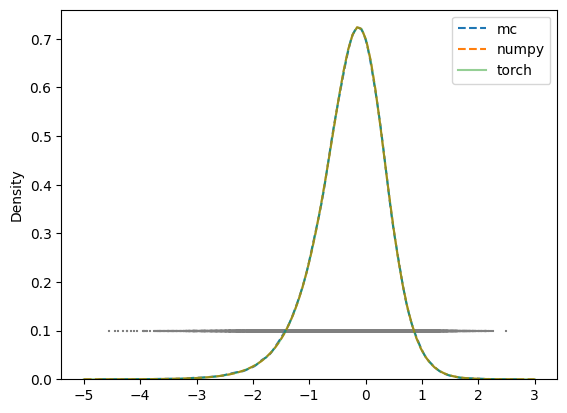

In [2]:
alpha = 3.0
delta = 1.0
beta = -1.0
mu = 0.1

evals = np.linspace(-5, 3, 100)
pdf = norminvgauss.pdf(evals, a=alpha*delta, b=beta*delta, loc=mu, scale=delta)

mu = torch.tensor(mu)
alpha = torch.tensor(alpha)
beta = torch.tensor(beta)
delta = torch.tensor(delta)
evals = torch.linspace(-5, 3, 100)
torch_pdf = torch.exp(NormalInverseGaussian(mu, alpha, beta, delta).log_prob(evals))

samples = NormalInverseGaussian(mu, alpha, beta, delta).sample((100000,))
mc_pdf = kdeplot(samples, label='mc', linestyle='--')

plt.plot(evals, pdf, label='numpy', linestyle='--')
plt.plot(evals, torch_pdf, label='torch', alpha=0.5)
plt.scatter(samples, 0.1 * torch.ones_like(samples), marker='+', s=1, c='grey')
plt.legend()
plt.show()

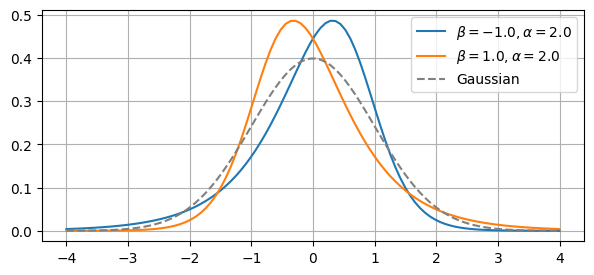

In [3]:
evals = torch.linspace(-4, 4, 100)

fig = plt.figure(figsize=(7, 3))

alpha = torch.tensor(2.0)
beta = torch.tensor(-1.0)
gamma = torch.sqrt(alpha**2 - beta**2)
delta = gamma**3 / alpha**2
mu = - delta * beta / gamma
torch_pdf = torch.exp(NormalInverseGaussian(mu, alpha, beta, delta).log_prob(evals))
plt.plot(evals, torch_pdf, label=rf'$\beta={beta.item():.1f}, \alpha={alpha.item():.1f}$')

alpha = torch.tensor(2.0)
beta = torch.tensor(1.0)
gamma = torch.sqrt(alpha**2 - beta**2)
delta = gamma**3 / alpha**2
mu = - delta * beta / gamma
torch_pdf = torch.exp(NormalInverseGaussian(mu, alpha, beta, delta).log_prob(evals))
plt.plot(evals, torch_pdf, label=rf'$\beta={beta.item():.1f}, \alpha={alpha.item():.1f}$')

gaussian_pdf = torch.exp(Normal(loc=torch.tensor(0.0), scale=torch.tensor(1.0)).log_prob(evals))

plt.plot(evals, gaussian_pdf, label='Gaussian', c='grey', linestyle='--')
plt.grid()
plt.legend()

return mean=0.100, std=0.200


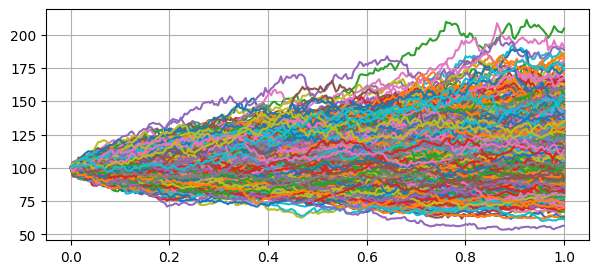

In [4]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
T = 1.0
S0 = torch.tensor(100.0)

alpha_true = torch.tensor(150.0)
beta_true = torch.tensor(-50.0)
gamma_true = torch.sqrt(alpha_true**2 - beta_true**2)
delta_true = 0.2**2 * gamma_true**3 / alpha_true**2
mu_true = 0.1 - delta_true * beta_true / gamma_true

nig_model = Nig(mu_true, alpha_true, beta_true, delta_true)
mean, std = nig_model.get_moments(t=1.0)
print(f'return mean={mean:.3f}, std={std:.3f}')

S = nig_model.simulate(S0, dt, T, M=1000)

plt.figure(figsize=(7, 3))
plt.plot(torch.linspace(0, T, S.shape[0]), S.detach())
plt.grid()
plt.show()

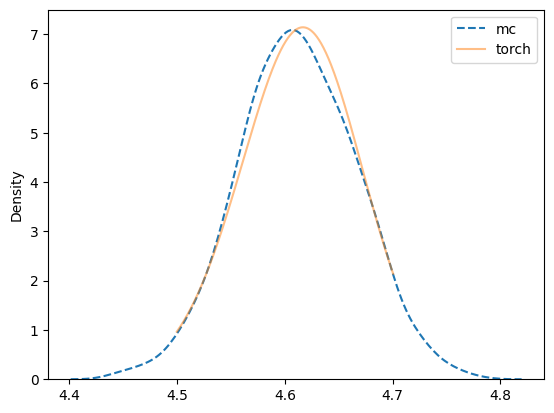

In [5]:
day = 20
log_r = torch.log(S[day, :])

mc_pdf = kdeplot(log_r, label='mc', linestyle='--')

evals = torch.linspace(90, 110, 1000)
pdf = torch.exp(nig_model.transition(S0, evals, delta_t=day / 252))
plt.plot(torch.log(evals), pdf.detach(), label='torch', alpha=0.5)

#plt.plot(torch.log(evals), gaussian_pdf.detach(), label='gaussian', alpha=0.5)
#plt.xlim((4.5, 4.7))
plt.legend()
plt.show()

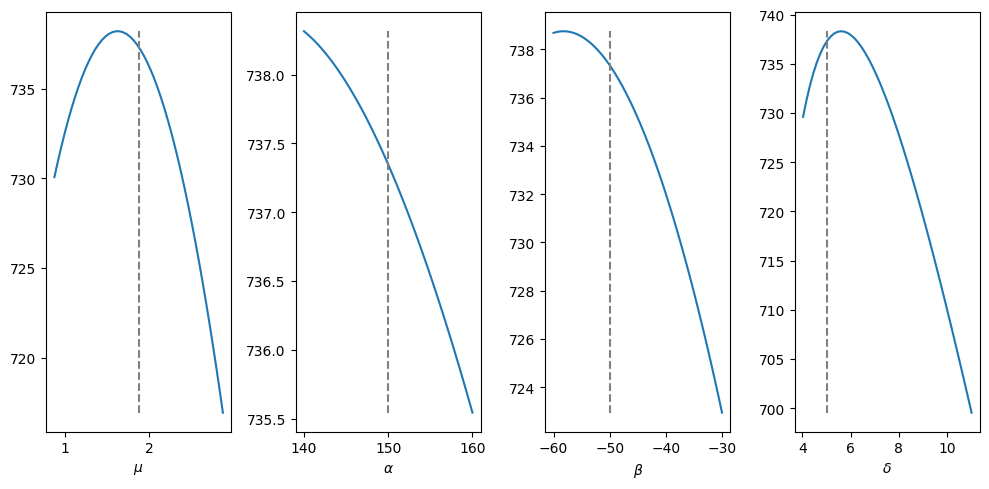

In [6]:
# Plot the likelihood slices, for one path only.
t = S.shape[0] - 1
spot = S[:, 0]

fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=4)

mus = torch.linspace(mu_true - 1.0, mu_true + 1.0, 50)
log_likelihood = torch.zeros_like(mus)
for i, mu in enumerate(mus):
    model = Nig(mu, alpha_true, beta_true, delta_true)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, window=t)

axs[0].plot(mus, log_likelihood.detach())
axs[0].vlines(mu_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[0].set_xlabel(r'$\mu$')

alphas = torch.linspace(alpha_true - 10, alpha_true + 10, 50)
log_likelihood = torch.zeros_like(alphas)
for i, alpha in enumerate(alphas):
    model = Nig(mu_true, alpha, beta_true, delta_true)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, window=t)

axs[1].plot(alphas, log_likelihood.detach())
axs[1].vlines(alpha_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[1].set_xlabel(r'$\alpha$')

betas = torch.linspace(beta_true - 10, beta_true + 20, 50)
log_likelihood = torch.zeros_like(betas)
for i, beta in enumerate(betas):
    model = Nig(mu_true, alpha_true, beta, delta_true)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, window=t)

axs[2].plot(betas, log_likelihood.detach())
axs[2].vlines(beta_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[2].set_xlabel(r'$\beta$')

deltas = torch.linspace(delta_true - 1.0, delta_true + 6.0, 50)
log_likelihood = torch.zeros_like(deltas)
for i, delta in enumerate(deltas):
    model = Nig(mu_true, alpha_true, beta_true, delta)
    log_likelihood[i] = model.forward(spot, t, delta_t=dt, window=t)

axs[3].plot(deltas, log_likelihood.detach())
axs[3].vlines(delta_true, ymin=log_likelihood.min().detach(), ymax=log_likelihood.max().detach(), color='grey', linestyle='--')
axs[3].set_xlabel(r'$\delta$')

plt.tight_layout()

/Users/ninocourtecuisse/Documents/ETHZ/MastersThesis/MastersThesis/.venv/lib/python3.11/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


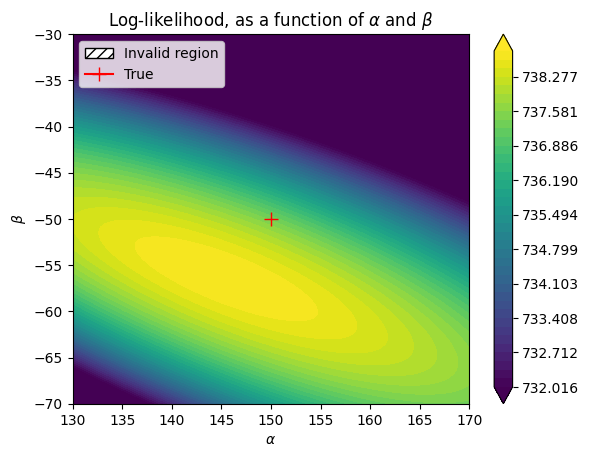

In [7]:
# Contour plot of the likelihood, as a function of alpha, beta
from matplotlib.patches import Patch
t = S.shape[0] - 1
spot = S[:, 0]

alphas = torch.linspace(alpha_true - 20, alpha_true + 20, 100)
betas = torch.linspace(beta_true - 20, beta_true + 20, 100)
alphas, betas = torch.meshgrid(alphas, betas)
log_likelihood = torch.zeros(size=(100, 100))
for i in range(alphas.shape[0]):
    for j in range(alphas.shape[1]):
        if betas[i, j].abs() < alphas[i, j]:
            model = Nig(mu_true, alphas[i, j], betas[i, j], delta_true)
            log_likelihood[i, j] = model.forward(spot, t, delta_t=dt, window=t)

mean = torch.mean(log_likelihood[log_likelihood > 0.0]).detach()
max = torch.max(log_likelihood[log_likelihood > 0.0]).detach()
levels = np.linspace(mean - 2.0 , max, 40)
contour = plt.contourf(alphas, betas, log_likelihood.detach(), levels=levels, cmap='viridis', extend='both')
plt.colorbar(contour)

contour0 = plt.contourf(alphas, betas, log_likelihood.detach(), levels=[-1e-10, 1e-10], colors=['white'], hatches=['///'])
marker_plot = plt.plot(alpha_true.item(), beta_true.item(), marker='+', color='red', markersize=10, label='True')

hatched_patch = Patch(facecolor='white', hatch='///', edgecolor='black', label='Invalid region')
plt.legend(handles=[hatched_patch] + marker_plot, loc='upper left')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title(r'Log-likelihood, as a function of $\alpha$ and $\beta$')
plt.show()

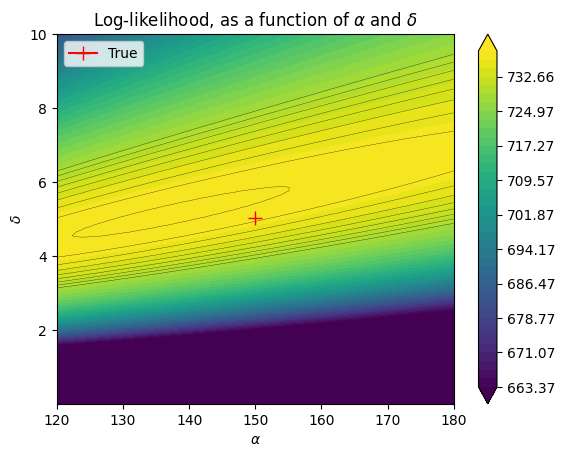

In [8]:
# Contour plot of the likelihood, as a function of alpha, beta
t = S.shape[0] - 1
spot = S[:, 0]

alphas = torch.linspace(alpha_true - 30, alpha_true + 30, 100)
deltas = torch.linspace(0.01, 10.0, 100)
alphas, deltas = torch.meshgrid(alphas, deltas)
log_likelihood = torch.zeros(size=(100, 100))
for i in range(alphas.shape[0]):
    for j in range(deltas.shape[1]):
        model = Nig(mu_true, alphas[i, j], beta_true, deltas[i, j])
        log_likelihood[i, j] = model.forward(spot, t, delta_t=dt, window=t)

mean = torch.mean(log_likelihood).detach().item()
min = torch.min(log_likelihood).detach().item()
max = torch.max(log_likelihood).detach().item()
levels = np.linspace(mean - 2.0 , max, 40)
#levels = np.linspace(mean - 2.0 , mean + 2.0, 40)
#levels = np.linspace(20000, 26000, 6000)
contour = plt.contourf(alphas, deltas, log_likelihood.detach(), levels=levels, cmap='viridis', extend='both')

levels = np.linspace(max - 10, max + 1, 10)
contour_line = plt.contour(alphas, deltas, log_likelihood.detach(), levels=levels, colors='black', linewidths=0.2)
plt.colorbar(contour)

marker_plot = plt.plot(alpha_true.item(), delta_true.item(), marker='+', color='red', markersize=10, label='True')
plt.legend(handles=marker_plot, loc='upper left')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\delta$')
plt.title(r'Log-likelihood, as a function of $\alpha$ and $\delta$')
plt.show()

-> Likelihood is very flat in the direction of alpha.  
It makes sense as alpha controles the heaviness of the tail, so we only have few observations useful to calibrate alpha.

In [23]:
# For each path, compute the MLE and estimate its mean and variance.
torch.manual_seed(42)
t = S.shape[0] - 1

n_paths = S.shape[1]
n_params = 4
stats = {
    "mle": torch.zeros(size=(n_paths, n_params)),
    "max_value": torch.zeros(size=(n_paths,)),
    "n_it": torch.zeros(size=(n_paths,)),
    "no_convergence": 0,
}

max_it = 10000
grad_norm_threshold = 1e-3
for i in range(3, 4):
    print(i)
    mu = Uniform(low=-1.0, high=3.0).sample()           # beta_true = 1.8
    alpha = Uniform(low=100.0, high=200.0).sample()     # alpha_true = 140
    beta = Uniform(low=-70, high=-20).sample()          # beta_true = -50
    delta = Uniform(low=0.1, high=10.0).sample()         # delta_true = 5.02

    print("Init: ", mu.item(), alpha.item(), beta.item(), delta.item())

    model = Nig(mu, alpha, beta, delta)
    #model.params["atanh_psi"] = torch.nn.Parameter(psi)
    #model.params["atanh_psi"].requires_grad = False
    #model.params["log_delta"].requires_grad = False
    #model.params["log_alpha"].requires_grad = False
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, maximize=True)
    spot_prices = S[:, i]
    for j in range(max_it):
        optimizer.zero_grad()
        loss = model.forward(spot_prices, t=t, delta_t=dt, window=t)
        loss.backward()
        total_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))
        
        mu = model.params["mu"].detach()
        delta = torch.exp(model.params["log_delta"].detach())
        alpha = torch.exp(model.params["log_alpha"].detach())
        psi = torch.tanh(model.params["atanh_psi"].detach())
        beta = psi * alpha
        print(f"Epoch {j}, Loss: {loss.item():.3f}, Grad Norm: {total_norm.item():.3f}, mu:{mu:.3f}, alpha: {alpha:.3f}, beta: {beta:.3f}, delta: {delta:.3f}")

        if total_norm < grad_norm_threshold:
            stats["n_it"][i] = j
            #print("Stopping: Gradient norm below threshold.")
            break
        if j == max_it - 1:
            stats["n_it"][i] = j
            stats["no_convergence"] += 1
            print("Maximum iteration reached.")
        optimizer.step()

    params = model.get_params()
    stats["mle"][i, 0] = params[0]
    stats["mle"][i, 1] = params[1]
    stats["mle"][i, 2] = params[2]
    stats["mle"][i, 3] = params[3]

    model = Nig(params[0], params[1], params[2], params[3])
    value = model.forward(spot_prices, t=t, delta_t=dt, window=t)
    stats["max_value"][i] = value

3
Init:  2.5290770530700684 191.50039672851562 -50.8568115234375 9.597126007080078
Epoch 0, Loss: 734.974, Grad Norm: 50.344, mu:2.529, alpha: 191.500, beta: -50.857, delta: 9.597
Epoch 1, Loss: 735.669, Grad Norm: 38.172, mu:2.539, alpha: 193.425, beta: -49.565, delta: 9.502
Epoch 2, Loss: 736.110, Grad Norm: 37.353, mu:2.540, alpha: 195.366, beta: -48.894, delta: 9.408
Epoch 3, Loss: 736.562, Grad Norm: 37.001, mu:2.535, alpha: 197.320, beta: -49.351, delta: 9.318
Epoch 4, Loss: 737.052, Grad Norm: 34.142, mu:2.528, alpha: 199.283, beta: -50.461, delta: 9.229
Epoch 5, Loss: 737.529, Grad Norm: 30.443, mu:2.521, alpha: 201.252, beta: -51.897, delta: 9.143
Epoch 6, Loss: 737.959, Grad Norm: 27.613, mu:2.512, alpha: 203.222, beta: -53.474, delta: 9.057
Epoch 7, Loss: 738.329, Grad Norm: 26.504, mu:2.505, alpha: 205.189, beta: -55.043, delta: 8.973
Epoch 8, Loss: 738.649, Grad Norm: 26.397, mu:2.498, alpha: 207.146, beta: -56.461, delta: 8.889
Epoch 9, Loss: 738.940, Grad Norm: 25.738, m

In [ ]:
spot_prices = S[:, 0]
m = torch.mean(torch.log(spot_prices[1:t+1] / spot_prices[0:t])) / dt \
                    - delta_true * beta_true / torch.sqrt(alpha_true**2 - beta_true**2)
print(m)

In [36]:
mean = torch.mean(stats["mle"], dim=0)
std = torch.std(stats["mle"], dim=0)
avg_it = torch.mean(stats["n_it"])
n_no_conv = stats["no_convergence"]

true_params = torch.tensor([alpha_true.item(), beta_true.item(), delta_true.item()])
avg_distance_to_argmax = torch.mean(torch.norm(stats["mle"] - true_params))

true_max_value = Nig(mu_true, alpha_true, beta_true, delta_true).forward(spot_prices, t=t, delta_t=dt, window=t).item()
avg_distance_to_max = torch.mean(torch.abs(stats["max_value"] - true_max_value)).item()

print(f"Average MLE: alpha:{mean[0].item():.3f}, beta:{mean[1].item():.3f}, delta:{mean[2].item():.3f}")
print(f"Std MLE: alpha:{std[0].item():.3f}, beta:{std[1].item():.3f}, delta:{std[2].item():.3f}")
print(f"Average distance to true parameter: {avg_distance_to_argmax.item():.3f}")
print(f"Average relative error to the true maximum: {((true_max_value - avg_distance_to_max) / true_max_value):.3f}")
print(f"Average number of iteration to convergence {avg_it.item():.3f}")
print(f"Number of parameters where GD didn't converge: {n_no_conv} / {n_paths}")

Average MLE: alpha:146.561, beta:-50.753, delta:3.179
Std MLE: alpha:38.620, beta:8.513, delta:0.772
Average distance to true parameter: 1294.281
Average relative error to the true maximum: 0.986
Average number of iteration to convergence 197.783
Number of parameters where GD didn't converge: 1 / 1000


Step   0: x = 2.900000, f(x) = 0.067155
Step   1: x = 2.800093, f(x) = 0.062049
Step   2: x = 2.700400, f(x) = 0.056259
Step   3: x = 2.601119, f(x) = 0.049697
Step   4: x = 2.502562, f(x) = 0.042273
Step   5: x = 2.405223, f(x) = 0.033906
Step   6: x = 2.309888, f(x) = 0.024550
Step   7: x = 2.217802, f(x) = 0.014237
Step   8: x = 2.130904, f(x) = 0.003165
Step   9: x = 2.052067, f(x) = -0.008188
Step  10: x = 1.985095, f(x) = -0.018958
Step  11: x = 1.933997, f(x) = -0.027960
Step  12: x = 1.901488, f(x) = -0.034077
Step  13: x = 1.887802, f(x) = -0.036748
Step  14: x = 1.890940, f(x) = -0.036130
Step  15: x = 1.907785, f(x) = -0.032867
Step  16: x = 1.934998, f(x) = -0.027777
Step  17: x = 1.969405, f(x) = -0.021646
Step  18: x = 2.008102, f(x) = -0.015133
Step  19: x = 2.048473, f(x) = -0.008739
Step  20: x = 2.088211, f(x) = -0.002816
Step  21: x = 2.125357, f(x) = 0.002409
Step  22: x = 2.158340, f(x) = 0.006814
Step  23: x = 2.185997, f(x) = 0.010347
Step  24: x = 2.207575, f(x)

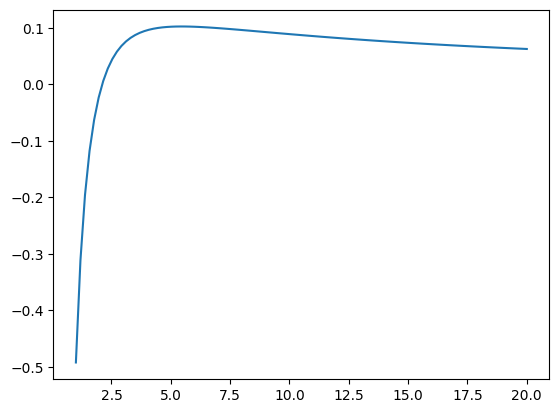

In [39]:
from torch.special import scaled_modified_bessel_k1 as k1_scaled
from torch.special import modified_bessel_k1 as k1

from torch.autograd import Function
from scipy.special import k0e, k1e

class ScaledBesselK1(Function):
    @staticmethod
    def forward(ctx, input):
        x_np = input.detach().cpu().numpy()
        scaled_k1 = k1e(x_np)
        ctx.save_for_backward(input)
        return torch.tensor(scaled_k1, dtype=input.dtype, device=input.device)

    @staticmethod
    def backward(ctx, grad_output):
        (input,) = ctx.saved_tensors
        input = input.detach()

        # Derivative of e^x * K1(x):
        # d/dx [e^x K1(x)] = e^x (K1(x) + K1'(x))
        # We use: K1'(x) = -K0(x) - K1(x)/x
        x_np = input.cpu().numpy()
        d_scaled_k1 = -k0e(x_np) + k1e(x_np) * (1 - 1 / x_np)

        grad_input = grad_output * torch.tensor(d_scaled_k1, dtype=input.dtype, device=input.device)
        return grad_input

def f(x):
    out = ScaledBesselK1.apply(x)
    return -torch.log(out) / x

def g(x):
    out = k1_scaled(x)
    return -torch.log(out) / x


eval = torch.linspace(1.0, 20.0, 100)
plt.plot(eval, g(eval))

x = torch.tensor([3.0], requires_grad=True)  # Initial guess
optimizer = torch.optim.Adam([x], lr=0.1)
for i in range(100):
    optimizer.zero_grad()
    loss = -g(x)  # maximize f ⇔ minimize -f
    loss.backward()
    optimizer.step()
    print(f"Step {i:3d}: x = {x.item():.6f}, f(x) = {g(x).item():.6f}")